# Detección de Anomalías con *Autoencoders*

## Introducción

En este ejemplo, se entrenará un *autoencoder* para detectar anomalías en el conjunto de datos CSE-CIC-IDS-2018. Este *dataset* contiene 16232943 flujos de red, cada uno con 36 características. Se utilizará una versión pre-procesada del conjunto de datos, en la que cada ejemplo ha sido etiquetado como 0 (correspondiente a un flujo de red normal), o 1 (correspondiente a un flujo de red anormal). El objetivo principal del modelo será la correcta **identificación de flujos anómalos**.

El CSE-CIC-IDS-2018 se trata de un conjunto de datos etiquetados, por lo que se podría plantear como un problema de aprendizaje supervisado. El objetivo de este ejemplo es ilustrar los conceptos de detección de anomalías que se pueden aplicar a conjuntos de datos más grandes, en los que no se dispone de etiquetas.

## ¿Qué es un *autoencoder*?

Autoencoder es una clase de Red Neuronal Artificial que permite aprender una representación latente (de dimensión reducida) de los datos de manera **no supervisada**. Lo que se busca es que, dado un conjunto de datos, cada elemento quede representado de manera biunívoca por unos pocos parámetros que permitan reconstruirlo, e incluso a veces generar nuevos datos no observados.

Un *autoencoder* es una clase de Red Neuronal Artificial que se entrena para copiar su entrada en su salida. Por ejemplo, dada una imagen de un dígito escrito a mano, un *autoencoder* primero codifica la imagen en una representación latente de menor dimensión, y luego decodifica la representación latente de vuelta a una imagen. Este, aprende a comprimir los datos minimizando el error de reconstrucción.

![](https://i2.wp.com/datasmarts.net/es/wp-content/uploads/2019/01/simple_autoencoder.png?w=588&ssl=1)

## ¿Cómo se detectan las anomalías con un *autoencoder*?

Un *autoencoder* se entrena para minimizar el error de reconstrucción. En el ejemplo anterior se han utilizado imágenes, pero se pueden utilizar cualquier tipo de datos numéricos para llevar a cabo su reconstrucción.

Se entrenará un *autoencoder* sólo con los flujos normales y luego se utilizará para reconstruir todos los datos. La hipótesis es que los flujos anómalos tendrán un mayor error de reconstrucción. Entonces, clasificará un ritmo como anómalo si el error de reconstrucción supera un umbral fijo, definido previamente, o basado en estadísticas de los flujos.

## Librerías necesarias

In [1]:
import gc
from os import getcwd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

pd.set_option("display.max_columns", 80)

## Carga del conjunto de datos

In [2]:
df = pd.read_csv('../Data Preprocess/autoencoder-preprocesed-2.csv', sep=',', low_memory=False)

num_cols = df.columns[:-3]
df

,Dst Port,xhr,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Fwd PSH Flags,Fwd Pkts/s,Bwd Pkts/s,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Protocol_6,Protocol_17,Label
0,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438890e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
1,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438851e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
2,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438887e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
3,0.000351,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,8.333333e-03,0.025000,0.0,1.0,0.0,0.898087,0.000015,0.357143,0.000000,1,0,0
4,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438874e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14597098,0.001221,0.707107,0.079193,0.0,0.037257,0.0,0.066158,0.003221,0.008549,0.012878,0.0,1.292872e-06,0.000005,1.0,1.0,0.0,0.125015,0.002289,0.357143,0.000000,1,0,0
14597099,0.001221,0.707107,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,8.134883e-07,0.000000,0.0,0.0,1.0,0.034164,0.000000,0.357143,0.000000,1,0,0
14597100,0.006760,0.707107,0.022627,0.0,0.017819,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.953125e-03,0.000000,0.0,0.0,1.0,0.966049,0.000000,0.357143,0.000000,1,0,0
14597101,0.764782,0.707107,0.015248,0.0,0.007174,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.666667e-01,0.000000,0.0,0.0,1.0,0.275742,0.000000,0.357143,0.000000,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14597103 entries, 0 to 14597102
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float64
 1   xhr                float64
 2   Fwd Pkt Len Max    float64
 3   Fwd Pkt Len Min    float64
 4   Fwd Pkt Len Mean   float64
 5   Bwd Pkt Len Min    float64
 6   Bwd Pkt Len Mean   float64
 7   Bwd IAT Tot        float64
 8   Bwd IAT Mean       float64
 9   Bwd IAT Max        float64
 10  Fwd PSH Flags      float64
 11  Fwd Pkts/s         float64
 12  Bwd Pkts/s         float64
 13  RST Flag Cnt       float64
 14  PSH Flag Cnt       float64
 15  ACK Flag Cnt       float64
 16  Init Fwd Win Byts  float64
 17  Init Bwd Win Byts  float64
 18  Fwd Seg Size Min   float64
 19  Idle Min           float64
 20  Protocol_6         int64  
 21  Protocol_17        int64  
 22  Label              int64  
dtypes: float64(20), int64(3)
memory usage: 2.5 GB


In [4]:
df.describe()

,Dst Port,xhr,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Fwd PSH Flags,Fwd Pkts/s,Bwd Pkts/s,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Protocol_6,Protocol_17,Label
count,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07
mean,1.452465e-01,4.963900e-01,8.862667e-02,1.904522e-02,3.358335e-02,2.108649e-02,5.084941e-02,9.632938e-03,1.114897e-02,1.377870e-02,3.919470e-02,6.777235e-03,8.404827e-03,1.703621e-01,3.620142e-01,3.358283e-01,1.223910e-01,1.393174e-01,3.179708e-01,1.269802e-02,7.015154e-01,2.853078e-01,1.151827e+00
std,2.953016e-01,2.593562e-01,1.415278e-01,3.379479e-02,3.862349e-02,3.839118e-02,6.461306e-02,6.340811e-02,4.771296e-02,4.559953e-02,1.940579e-01,3.739129e-02,4.757323e-02,3.759506e-01,4.805829e-01,4.722792e-01,2.354339e-01,3.235936e-01,1.420988e-01,7.316006e-02,4.575932e-01,4.515610e-01,2.695378e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.087282e-04,2.588190e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.546002e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.428571e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.220722e-03,5.000000e-01,1.918347e-02,0.000000e+00,2.429823e-02,0.000000e+00,3.307921e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.952569e-05,2.888951e-06,0.000000e+00,0.000000e+00,0.000000e+00,4.257202e-03,0.000000e+00,3.571429e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,5.171283e-02,7.071068e-01,7.919331e-02,5.128205e-02,4.180838e-02,4.102564e-02,7.537721e-02,4.942583e-04,1.493844e-03,1.487633e-03,0.000000e+00,5.868545e-04,5.040323e-04,0.000000e+00,1.000000e+00,1.000000e+00,1.250153e-01,3.448486e-03,3.571429e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01


Text(0.5, 1.0, 'Distribución del tráfico')

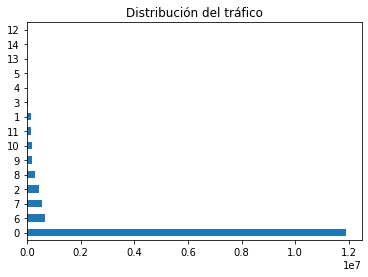

In [5]:
df['Label'].value_counts().plot(kind='barh')
plt.title('Distribución del tráfico')

In [6]:
# 1 -> DoS
# 2 -> DDoS
# 3 -> Botnet
# 4 -> Bruteforce
# 5 -> Infiltration
# 6 -> Web attack
df.replace(to_replace=2, value=1, inplace=True)     # DoS attack
df.replace(to_replace=3, value=1, inplace=True)     # DoS attack
df.replace(to_replace=4, value=1, inplace=True)     # DoS attack
df.replace(to_replace=5, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=6, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=7, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=8, value=3, inplace=True)     # Botnet attack
df.replace(to_replace=9, value=4, inplace=True)     # Bruteforce attack
df.replace(to_replace=10, value=4, inplace=True)    # Bruteforce attack
df.replace(to_replace=11, value=5, inplace=True)    # Infiltration attack
df.replace(to_replace=12, value=6, inplace=True)    # Web attack
df.replace(to_replace=13, value=6, inplace=True)    # Web attack
df.replace(to_replace=14, value=6, inplace=True)    # Web attack
df['Label'].unique()

array([0, 1, 5, 3, 6, 2, 4])

Text(0.5, 1.0, 'Distribución del tráfico')

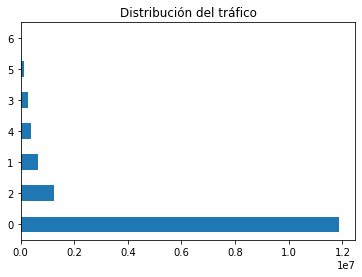

In [7]:
df['Label'].value_counts().plot(kind='barh')
plt.title('Distribución del tráfico')

In [8]:
df

,Dst Port,xhr,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Fwd PSH Flags,Fwd Pkts/s,Bwd Pkts/s,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Protocol_6,Protocol_17,Label
0,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438890e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
1,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438851e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
2,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438887e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
3,0.000351,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,8.333333e-03,0.025000,0.0,1.0,0.0,0.898087,0.000015,0.357143,0.000000,1,0,0
4,0.000000,0.866025,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.438874e-09,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.551961,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14597098,0.001221,0.707107,0.079193,0.0,0.037257,0.0,0.066158,0.003221,0.008549,0.012878,0.0,1.292872e-06,0.000005,1.0,1.0,0.0,0.125015,0.002289,0.357143,0.000000,1,0,0
14597099,0.001221,0.707107,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,8.134883e-07,0.000000,0.0,0.0,1.0,0.034164,0.000000,0.357143,0.000000,1,0,0
14597100,0.006760,0.707107,0.022627,0.0,0.017819,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.953125e-03,0.000000,0.0,0.0,1.0,0.966049,0.000000,0.357143,0.000000,1,0,0
14597101,0.764782,0.707107,0.015248,0.0,0.007174,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.666667e-01,0.000000,0.0,0.0,1.0,0.275742,0.000000,0.357143,0.000000,1,0,0


## Tratamiento del conjunto de datos

Se eliminan atributos que son irrelevantes a priori.

Text(0.5, 1.0, 'Correlación respecto a target')

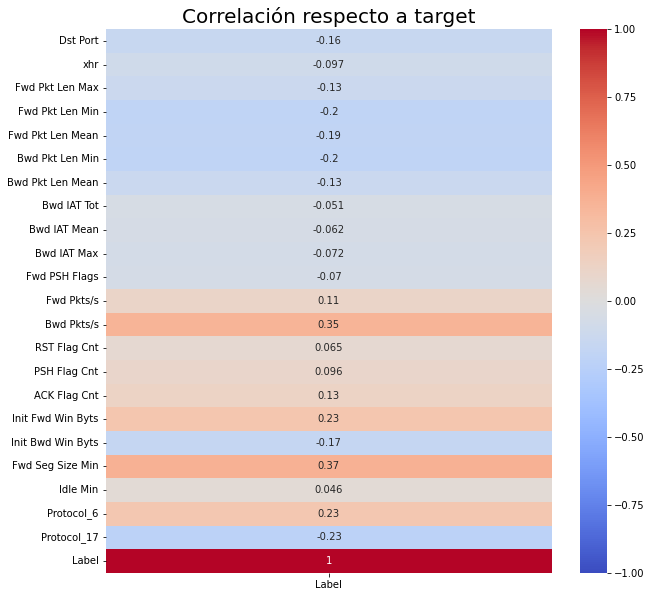

In [9]:
corr = df.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

In [10]:
kot = df.corr()
drop_cols = []
i = -1
for corr in kot['Label']:
    i+=1
    if abs(corr) < 0.15:
        drop_cols.append(df.columns[i])

In [11]:
df.drop(drop_cols, axis=1, inplace=True)

Text(0.5, 1.0, 'Correlación respecto a target')

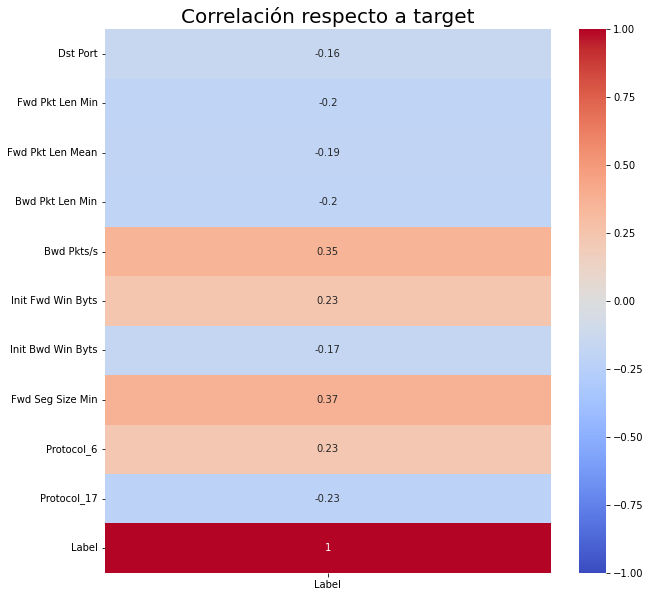

In [12]:
corr = df.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

## Partición de conjuntos normales y anómalos

Se entrenará el autoencoder utilizando sólo los flujos normales, que en este conjunto de datos están etiquetados como 0. Deben separarse los flujos normales de los anómalos.

In [13]:
y = df.pop('Label')
X = df.values

In [14]:
# Partición del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [15]:
def count_values(array):
    y = np.bincount(array)
    ii = np.nonzero(y)[0]
    return np.vstack((ii,y[ii])).T

In [16]:
count_values(y_train)

array([[      0, 8321233],
       [      1,  444327],
       [      2,  885080],
       [      3,  200526],
       [      4,  266748],
       [      5,   99400],
       [      6,     658]])

In [17]:
count_values(y_test)

array([[      0, 3567467],
       [      1,  190047],
       [      2,  378823],
       [      3,   85642],
       [      4,  114201],
       [      5,   42681],
       [      6,     270]])

In [18]:
train_data = tf.cast(X_train, tf.float32)
test_data = tf.cast(X_test, tf.float32)

In [19]:
train_labels = tf.cast(y_train, tf.int16)
test_labels = tf.cast(y_test, tf.int16)

In [20]:
# Flujos normales
normal_train_data = X_train[np.where(train_labels == 0)]
normal_test_data = X_test[np.where(test_labels == 0)]

In [21]:
clfIF = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, n_jobs=-1)
clfIF.fit(pd.DataFrame(normal_train_data))
pred_train = clfIF.predict(pd.DataFrame(normal_train_data))

In [22]:
normal = pd.DataFrame(normal_train_data)
normal['anomaly'] = pred_train
outliers = normal.loc[normal['anomaly']==-1]
outlier_index = list(outliers.index)
print(normal['anomaly'].value_counts())
normal.drop(['anomaly'], axis=1, inplace=True)

 1    6870897
-1    1450336
Name: anomaly, dtype: int64


In [23]:
normal = normal.iloc[normal.index.difference(outlier_index)]
normal.reset_index(drop=True, inplace = True)
normal.describe()

,0,1,2,3,4,5,6,7,8,9
count,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06,6.870897e+06
mean,1.257543e-01,2.305680e-02,3.247973e-02,2.510226e-02,1.149465e-03,4.817729e-02,1.701336e-01,2.798167e-01,6.339944e-01,3.660056e-01
std,2.770491e-01,3.087340e-02,3.048386e-02,3.670625e-02,3.967966e-03,6.630814e-02,3.599827e-01,1.049173e-01,4.817111e-01,4.817111e-01
min,1.525902e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.428571e-01,0.000000e+00,0.000000e+00
25%,8.087282e-04,0.000000e+00,7.173763e-03,0.000000e+00,5.122820e-07,0.000000e+00,0.000000e+00,1.428571e-01,0.000000e+00,0.000000e+00
50%,1.220722e-03,0.000000e+00,2.638093e-02,0.000000e+00,5.218782e-06,3.921509e-03,0.000000e+00,3.571429e-01,1.000000e+00,0.000000e+00
75%,5.171283e-02,5.769231e-02,3.725728e-02,4.908425e-02,5.050505e-04,1.250153e-01,3.906250e-03,3.571429e-01,1.000000e+00,1.000000e+00
max,1.000000e+00,1.266026e-01,1.603683e-01,5.904762e-01,4.166667e-02,9.844513e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [24]:
X_train = normal.values

In [25]:
X_train.shape

(6870897, 10)

In [26]:
del(df, clfIF, pred_train, outliers, outlier_index)
gc.collect()

84

Flujo de red normal.

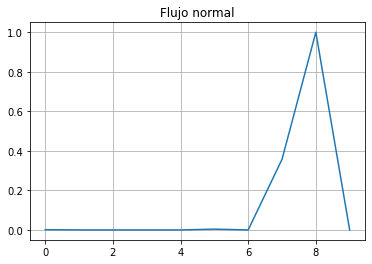

In [27]:
plt.grid()
plt.plot(np.arange(X_train.shape[1]), normal_train_data[0])
plt.title("Flujo normal")
plt.show()

Flujo de red anómalo.

In [28]:
dos_data = X_test[np.where(test_labels == 1)]

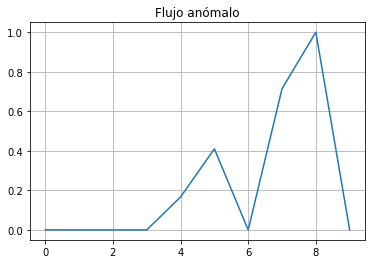

In [29]:
plt.grid()
plt.plot(np.arange(X_train.shape[1]), dos_data[0])
plt.title("Flujo anómalo")
plt.show()

In [30]:
del(dos_data)
gc.collect()

5920

## Construyendo el modelo

In [31]:
class AnomalyDetector(Model):
    
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(X_train.shape[1]*2, activation="relu"),
            layers.Dense(X_train.shape[1], activation="relu"),
            layers.Dense(X_train.shape[1]/2, activation="relu"),
            layers.Dense(3, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(X_train.shape[1], activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def pred(self, data, threshold):
        reconstructions = self(data)
        loss = tf.keras.losses.mae(reconstructions, data)
        return tf.math.less(threshold, loss)

    def print_stats(self, predictions, labels):
        labels = np.where(labels > 0, 1, labels)
        labels = labels.astype(bool)
        print("Accuracy = {}".format(accuracy_score(labels, preds)))
        print("Precision = {}".format(precision_score(labels, preds)))
        print("Recall = {}".format(recall_score(labels, preds)))

In [32]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

Obsérvese que el *autoencoder* se entrena utilizando sólo los flujos normales, pero se evalúa utilizando el conjunto de pruebas completo.

In [33]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=500, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/500
16253/16253 [==============================] - 43s 3ms/step - loss: 0.0570 - val_loss: 0.0470
Epoch 2/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0355 - val_loss: 0.0366
Epoch 3/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0344 - val_loss: 0.0361
Epoch 4/500
16253/16253 [==============================] - 41s 2ms/step - loss: 0.0341 - val_loss: 0.0358
Epoch 5/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0339 - val_loss: 0.0358
Epoch 6/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0337 - val_loss: 0.0358
Epoch 7/500
16253/16253 [==============================] - 41s 2ms/step - loss: 0.0336 - val_loss: 0.0357
Epoch 8/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0336 - val_loss: 0.0354
Epoch 9/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0335 - val_loss: 0.0355
Epoch 10/500
16253/16253 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0325 - val_loss: 0.0342
Epoch 138/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0325 - val_loss: 0.0341
Epoch 139/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0325 - val_loss: 0.0341
Epoch 140/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0325 - val_loss: 0.0345
Epoch 141/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0325 - val_loss: 0.0343
Epoch 142/500
  695/16253 [>.............................] - ETA: 30s - loss: 0.0326

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 40s 2ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 156/500
14715/16253 [==========================>...] - ETA: 3s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 159/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 160/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 161/500
 7298/16253 [============>.................] - ETA: 17s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 175/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 176/500
 7821/16253 [=============>................] - ETA: 16s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 178/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0339
Epoch 179/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 180/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 181/500
  614/16253 [>.............................] - ETA: 29s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 193/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 194/500
 1728/16253 [==>...........................] - ETA: 29s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 196/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0341
Epoch 197/500
 3014/16253 [====>.........................] - ETA: 27s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 199/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 200/500
 3407/16253 [=====>........................] - ETA: 24s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0339
Epoch 212/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0339
Epoch 213/500
 8178/16253 [==============>...............] - ETA: 16s - loss: 0.0324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0324 - val_loss: 0.0339
Epoch 215/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 216/500
 9762/16253 [=================>............] - ETA: 13s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 218/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 219/500
 6579/16253 [===========>..................] - ETA: 19s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 231/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0323 - val_loss: 0.0343
Epoch 232/500
13910/16253 [========================>.....] - ETA: 4s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 235/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 236/500
12727/16253 [======================>.......] - ETA: 6s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 249/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0323 - val_loss: 0.0341
Epoch 250/500
 4086/16253 [======>.......................] - ETA: 23s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 40s 2ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 253/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 254/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 255/500
 7255/16253 [============>.................] - ETA: 18s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 266/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 267/500
15993/16253 [============================>.] - ETA: 0s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 271/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 272/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 273/500
 4678/16253 [=======>......................] - ETA: 23s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 285/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 286/500
 7472/16253 [============>.................] - ETA: 17s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 290/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 291/500
12979/16253 [======================>.......] - ETA: 6s - loss: 0.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 303/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 304/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 305/500
 1030/16253 [>.............................] - ETA: 28s - loss: 0.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 308/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0343
Epoch 309/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 310/500
 4376/16253 [=======>......................] - ETA: 23s - loss: 0.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16253/16253 [==============================] - 43s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 313/500
16253/16253 [==============================] - 43s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 314/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 315/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 316/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 317/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0341
Epoch 318/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 319/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 320/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 321/500
16253/16253 [===============

Epoch 388/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 389/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0340
Epoch 390/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0340
Epoch 391/500
16253/16253 [==============================] - 41s 2ms/step - loss: 0.0322 - val_loss: 0.0342
Epoch 392/500
16253/16253 [==============================] - 40s 2ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 393/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0339
Epoch 394/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 395/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0322 - val_loss: 0.0339
Epoch 396/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0340
Epoch 397/500
16253/16253 [=

Epoch 464/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 465/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0337
Epoch 466/500
16253/16253 [==============================] - 42s 3ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 467/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0337
Epoch 468/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0339
Epoch 469/500
16253/16253 [==============================] - 41s 2ms/step - loss: 0.0322 - val_loss: 0.0337
Epoch 470/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 471/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0344
Epoch 472/500
16253/16253 [==============================] - 41s 3ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 473/500
16253/16253 [=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



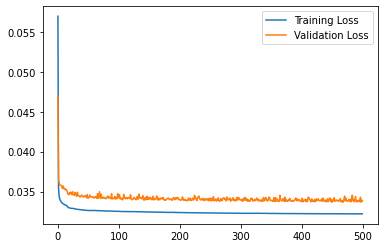

In [34]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Interpretación de resultados

Posteriormente se podrá clasificar un flujo como anómalo si el error de reconstrucción es mayor que una desviación estándar de los ejemplos de entrenamiento normales. En primer lugar, vamos a trazar un flujo normal del conjunto de entrenamiento, la reconstrucción después de ser codificado y decodificado por el *autoencoder*, y el error de reconstrucción.

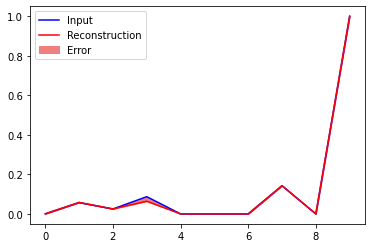

In [35]:
encoded_flows = autoencoder.encoder(normal_test_data).numpy()
decoded_flows = autoencoder.decoder(encoded_flows).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_flows[0], 'r')
plt.fill_between(np.arange(X_train.shape[1]), decoded_flows[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Ahora trazamos un gráfico similar, esta vez para un ejemplo de un flujo anómalo.

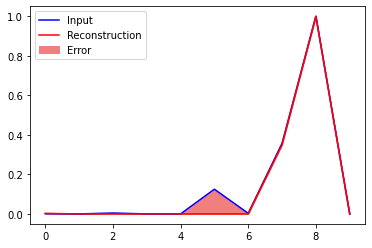

In [36]:
anomalous_test_data = X_test[np.where(test_labels > 0)]
encoded_flows = autoencoder.encoder(anomalous_test_data).numpy()
decoded_flows = autoencoder.decoder(encoded_flows).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_flows[0], 'r')
plt.fill_between(np.arange(X_train.shape[1]), decoded_flows[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Detección de anomalías

Las anomalías son detectadas calculando si la pérdida de reconstrucción es mayor que un umbral fijo. Se calculará el error medio de los ejemplos normales del conjunto de entrenamiento, y después se clasificarán los futuros ejemplos como anómalos si el error de reconstrucción es superior a una desviación estándar del conjunto de entrenamiento.

111484/111484 [==============================] - 113s 1ms/step


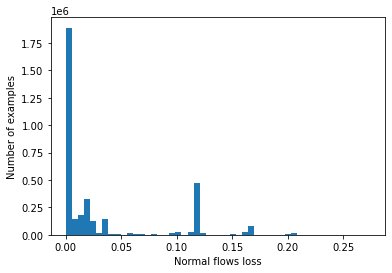

In [37]:
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Normal flows loss")
plt.ylabel("Number of examples")
plt.show()

In [38]:
th = 0.018

In [39]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: " + str(threshold))

Threshold: 0.08092648195718755


5939/5939 [==============================] - 6s 1000us/step


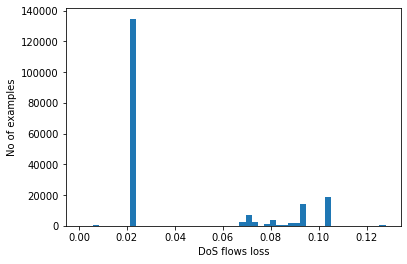

Anomalies detected: 99.79636616205465 %.


In [40]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 1)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 1)[0]])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DoS flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

11839/11839 [==============================] - 12s 1ms/step


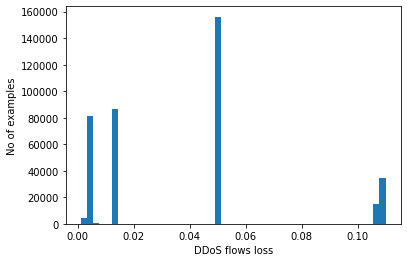

Anomalies detected: 54.2174049622119 %.


In [41]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 2)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 2)])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DDoS flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

2677/2677 [==============================] - 3s 999us/step


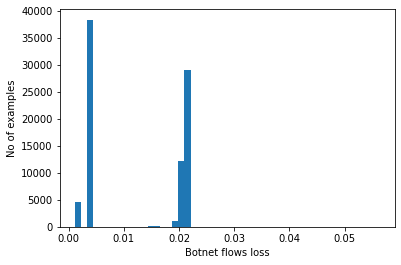

Anomalies detected: 49.534107096985124 %.


In [42]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 3)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 3)])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Botnet flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

3569/3569 [==============================] - 4s 975us/step


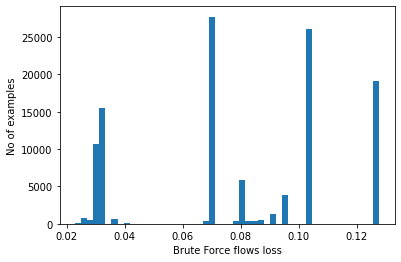

Anomalies detected: 100.0 %.


In [43]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 4)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 4)])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Brute Force flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

1334/1334 [==============================] - 1s 1ms/step


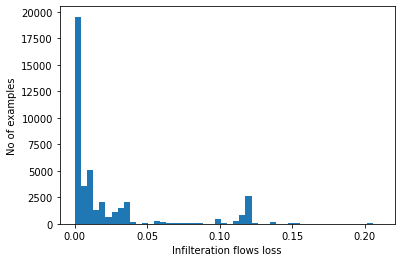

Anomalies detected: 27.614160867833466 %.


In [44]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 5)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 5)])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Infilteration flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

9/9 [==============================] - 0s 960us/step


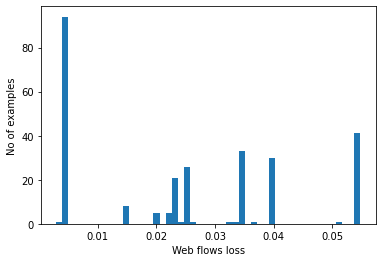

Anomalies detected: 61.85185185185185 %.


In [45]:
reconstructions = autoencoder.predict(X_test[np.where(test_labels == 6)])
test_loss = tf.keras.losses.mae(reconstructions, X_test[np.where(test_labels == 6)])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Web flows loss")
plt.ylabel("No of examples")
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

In [46]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

Deberemos elegir el valor de *threshold* que mejor creemos que separa las anomalías.

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

              precision    recall  f1-score   support

           0       0.91      0.69      0.78   3567467
           1       0.33      0.69      0.45    811664

    accuracy                           0.69   4379131
   macro avg       0.62      0.69      0.62   4379131
weighted avg       0.80      0.69      0.72   4379131

AUC: 69.0%


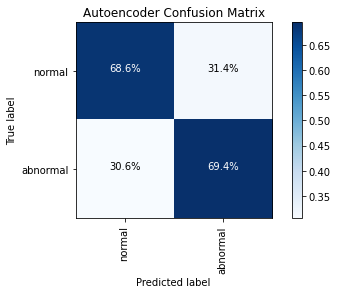

In [49]:
labels = np.where(y_test > 0, 1, y_test)
print(classification_report(labels, preds))
print('AUC:','{:.1%}'.format(roc_auc_score(labels, preds)))
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, title='Autoencoder Confusion Matrix')